# Explanations:

- выборка - тензор из картинок, таргет - вектор силы

---

Авторы используют multi output GPR, настраивая гиперпараметры $\sigma_{cov}$ и $\sigma_{err}$ (можно однозначно их выразить через гиперпараметры из того же sklearn: $l$ и $\sigma$)

GPR - непараметрический метод, суть в том, что мы делаем предположение о виде матрицы корреляции признаков для известных данных.

---

Моделирование в хотя бы немного более сложном случае буду писать на Julia

---

Гиперпараметры:

1)k: Количество элементов в массивах r_cut и p для каждого атома

2)$r_{cut}(i)_j$, i=1..k, j=1..N: векторы r_cut для j атома тоже параметр

3)$p_(i)_j$, i=1..k, j=1..N: векторы p для j атома тоже параметр

4)N_neighbours for summation for IVs

В GPyTorch есть имплементация многоразмерного регрессора: https://docs.gpytorch.ai/en/stable/examples/03_Multitask_Exact_GPs/index.html#multi-output-vector-valued-functions

---

Пока что все размерности предполагаются в системе LJ, потому что пока пытаюсь это зафитить

Исходно пока в coords.csv и forces.csv находятся для 2 частиц данные

In [37]:
!pip install torchvision

     |████████████████████████████████| 23.3 MB 8.6 MB/s            
     |████████████████████████████████| 881.9 MB 14 kB/s              
     |████████████████████████████████| 3.1 MB 11.0 MB/s            
  Attempting uninstall: torch
    Found existing installation: torch 1.10.2
    Uninstalling torch-1.10.2:
      Successfully uninstalled torch-1.10.2
  Attempting uninstall: pillow
    Found existing installation: Pillow 4.2.1
    Uninstalling Pillow-4.2.1:
      Successfully uninstalled Pillow-4.2.1


In [26]:
import random
import os
import time

from numba import jit, njit, vectorize
import numpy as np
import scipy
from numpy.linalg import norm as norm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [27]:
def set_seed(seed = 42):
    '''
    
    Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.

    '''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()

---

# Hyperparameters:

In [28]:
class CFG:
    '''

    All hyperparameters are here

    '''

    N = 2     # число атомов
    K = 2     # можно называть это разрешением...чем число больше, тем больше размеры матрицы для атомов, фактически это число элементов в наборах p и r_cut

    L = L = 2 * N ** (1 / 3) # размер одной клетки при моделировании

    p = (np.random.rand(K) + 0.1).copy()
    r_cut = (np.random.rand(K) + 0.1).copy()

    N_neig= N - 1 if N != 2 else 1

    # train_bs = 8
    # val_bs = 16
    batch_size = 256

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    f_threshold = 10    # Если сила по какой-то координате превышает это значение, то строчка исключается, совсем маленьких по модулю сил быть не должно, если что при генерации просто r_cut поменьше надо делать
    coord_threshold = 2 * L     # Если вдруг очень большие расстояния, то надо выкидывать
    #
    output_size = 3     # Размерность аутпута модели

---

Имеется два .csv файла:

1)
| Id(time) | 1_x | 1_y | 1_z | ... | N_z |
|------|-----|-----|-----|-----|-----|
|      |     |     |     |     |     |
|      |     |     |     |     |     |
2)
| Id(time) | f_1_x | f_1_y | f_1_z | ... | f_N_z |
|------|-----|-----|-----|-----|-----|
|      |     |     |     |     |     |
|      |     |     |     |     |     |

Одна строчка отсюда превращается в N матриц (на каждый атом) с N векторами сил

В идеале сделать БДху из двух сущностей: сила и координата, где полями будут их проекции

In [29]:
def create_df_with_coords(coords_file_path = None, forces_file_path = None):
    '''
    just makes df from .csvs with coords and forces
    '''
    coords = pd.read_csv(coords_file_path)

    forces = pd.read_csv(forces_file_path)

    if CFG.N != int(coords.columns[-1][:-1]) + 1:
        raise Exception('Constant N is not equal to amount of particles in .csv')

    return pd.merge(left=coords, right=forces, on='t').drop('t', axis='columns')

In [30]:
a = set([1, 2])
b = set([2, 3])

a.union(b)

{1, 2, 3}

12 индекс - 1 отн 2

$$
\vec{r_1} = \vec{r_2} + \vec{r}_{12}
$$

$$
\vec{r}_{12} = \vec{r_1} - \vec{r}_{2}
$$

In [31]:
def _get_relative_positions(row, atom_number):
    '''
    This function processes one row of csv into something that we can work with

    Returns np.array matrix that consists of relative positions vectors for passed atom_number to every other atom
    and then we can chose only closest N_neighbours in the next functions
    
    row: df.iloc[row] - typeof(row): pd.Series
    
    returns: Rel_matrix, f_vec
    '''

    s_coord = pd.Series(dtype=float)
    other_atom_numbers = [i for i in range(CFG.N) if i != atom_number]

    for other_numb in other_atom_numbers:
        index = str(atom_number) + str(other_numb)
        for axis in ['x', 'y', 'z']:
            s_coord[index + axis] = row[str(atom_number) + axis] - row[str(other_numb) + axis]

    # we need force vector only for atom_number:
    force_vec = []
    for f_axis in ['f_x', 'f_y', 'f_z']:
        force_vec.append(row[str(atom_number) + f_axis])
        

    Rel_matrix = []
    cur_vector = []

    for (i, elem) in enumerate(s_coord.values):
        if i % 3 == 0 and i != 0:
            Rel_matrix.append(cur_vector)
            cur_vector = []

        cur_vector.append(elem)
    Rel_matrix.append(cur_vector)

    return np.array(Rel_matrix), np.array(force_vec)

In [32]:
from sklearn.preprocessing import normalize

In [33]:
@njit(fastmath=True)
def make_one_vec_transformed(vec, vec_norm, r_cut_i, p_i):
    '''
    vec: np.array - normalized vector
    norm: its norm
    r_cut_i: i-th component of
    '''
    return vec * np.exp(
        -np.power((vec_norm / r_cut_i), p_i)
        )

make_matrix_transformed = np.vectorize(make_one_vec_transformed)

def create_V_i(i, normalized_m, norms, r_cut=CFG.r_cut, p=CFG.p):
    '''
    normalized_m: matrix of relative distances, where rows - normalized vectors
    i: i-th component of r_cut and p, i in range 1..K (or in 0..K-1 in code)
    '''
    transf_vecs = make_matrix_transformed(normalized_m, norms[:, np.newaxis], r_cut[i], p[i])

    return np.sum(transf_vecs, axis=0)

# @njit(parallel=True)
def create_V(normalized_m, norms, K=CFG.K):
    '''
    creates V
    '''
    V = []
    for i in range(K):
        V.append(
            create_V_i(i, normalized_m, norms)
        )

    return np.array(V)

In [34]:
# @njit(
#     # parallel=True,
#     # fastmath=True
#     )
def _calculate_matrix_for_atom(relative_distances, r_cut=CFG.r_cut, p=CFG.p, N_neig=CFG.N_neig, K=CFG.K):
    '''

    relative_distances: np.array matrix of relative distance vectors

    '''

    norms = norm(relative_distances, axis=-1)
    
    # Only closest N_neig are counting:
    indexlist = np.argsort(norm(relative_distances, axis=1))
    relative_distances = relative_distances[indexlist[len(relative_distances) - N_neig:]]

    normalized_rel_distances = relative_distances / norms[:, np.newaxis]

    # print(
    #     create_V_i(0, normalized_rel_distances, norms), f'{CFG.r_cut=}, {CFG.p=}'
    # )

    V = create_V(normalized_rel_distances, norms)

    # print(f'V:\n {V}\n norms:\n {norm(V, axis=-1)[:, np.newaxis]}\n normed_V:\n {V / norm(V, axis=-1)[:, np.newaxis]}')
    
    # print(V / norm(V, axis=-1)[:, np.newaxis])
    if np.inf in V / norm(V, axis=-1)[:, np.newaxis] or np.nan in V / norm(V, axis=-1)[:, np.newaxis]:
        print(f'V:\n {V}\n norms:\n {norm(V, axis=-1)[:, np.newaxis]}\n normed_V:\n {V / norm(V, axis=-1)[:, np.newaxis]}')
        print(f'ABOUT RELATIVE DISTANCES:\n rel_dists:\n {relative_distances}\n norms:\n{norms}\n normalized_rel_dists:\n {normalized_rel_distances}')

    A = V / norm(V, axis=-1)[:, np.newaxis]

    X = V @ A.T

    return X

In [35]:
def get_matrix_for_atom(row = None, atom_number = None):
    '''

    This function will create X matrix for passed atom with
    arrays of r_cut and p of length k

    It is a wrapper for _get_relative_positions and _calculate_matrix_for_atom, so I can speed up matrix calculations
    with numba for _calculate_matrix_for_atom

    atom_number: a number of atom that we are passing
    row: one row from df_with_coords, i.e. df.iloc[index_of_row]

    '''

    # creating row of relative coordinates for concrete atom:
    relative_distances, f_vec = _get_relative_positions(row=row, atom_number=atom_number)
    X = _calculate_matrix_for_atom(relative_distances=relative_distances)
    
    return X, f_vec

# %timeit get_matrix_for_atom(row=df.iloc[0], atom_number=1)

In [38]:
from tqdm import tqdm
import gc
import torchvision.transforms as transforms

**У нас будет train и val выборки, все-таки выборку, для который известен таргет принято называть validation, на которой мы качество оцениваем, а test это все-таки выборка, для который неизвестны таргеты**

In [39]:
def clean_df(df: pd.DataFrame, f_threshold = CFG.f_threshold, coord_threshold=CFG.coord_threshold):
    '''

    Убирает строчки с аномально большими силами из df

    '''

    indexes_for_deletion = set()

    for numb in range(CFG.N):
        for coord in ['f_x', 'f_y', 'f_z']:

            indexes_for_deletion = indexes_for_deletion.union(
                set(df[abs(df[str(numb) + coord]) > f_threshold].index)
            )

        for coord in ['x', 'y', 'z']:
            indexes_for_deletion = indexes_for_deletion.union(
                set(df[abs(df[str(numb) + coord]) > coord_threshold].index)
            )

    return df.drop(list(indexes_for_deletion))

In [40]:
def create_tensor_dataset(coords_file_path = 'coords.csv', forces_file_path = 'forces.csv', step=1, transform=transforms.ToTensor(), length=None,
    f_threshold=CFG.f_threshold, coord_threshold=CFG.coord_threshold):
    '''

    Примитивная версия датасета, просто все будет хранить в одном тензоре...

    Эта функция - wrapper на все выше написанные функции, она по переданным путям к .csv
    возвращает тензор из матриц для каждого атома в каждой строчке и тензор из векторов сил


    ИНогда есть смысл делать побольше шаг между соседними строчками, поскольку если есть почти одинаковые матрицы, то
    это по-сути линейная зависимость и модель тогда надо сильнее регулизировать

    transform: преобразование к X части датасета, в основном для нормализации нужно
    step: через сколько строчек шагать при чтении csv в датасет, чтобы уж совсем одинаковых не было

    '''

    dataset = []

    df = create_df_with_coords(coords_file_path=coords_file_path, forces_file_path=forces_file_path)
    if length:
        df = df.loc[range(length)]

    # Сюда будет вставлена чистка df от больших сил
    df = clean_df(df, f_threshold=f_threshold, coord_threshold=coord_threshold)

    row_indexes = [i for i in range(0, len(df.index), step)]

    for atom_number in range(CFG.N):
        for index in tqdm(row_indexes, desc=f'Progress for atom {atom_number}'):
            row = df.iloc[index]
            x, f = get_matrix_for_atom(row=row, atom_number=atom_number)

            if transform:
                x = transform(x)
            else:
                x = transforms.ToTensor()(x)
            x = x.to(torch.float)

            dataset.append(
                (x, torch.tensor(f, dtype=torch.float))
                )
            
            # В дальнейшем для других моделей может иметь смысл хранить и возвращать тут (x, f, A), где A - соответствующая матрица для X

    gc.collect()

    return dataset

In [41]:
# Когда только начинаю работать с датасетом надо один раз на трейне посчитать std и mean, чтобы нормализовать можно было

mean = 0.1193004623055458
std = 0.09002102166414261

In [42]:
# все-таки у нас тут не картинки будут, поэтому я попробую сначала даже без нормализации, нормализовать надо 1 канал, если в терминах картинки рассуждать

transform = transforms.Compose([                                    
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),                    
])

In [43]:
# dataset = create_tensor_dataset('coords.csv', 'forces.csv', step=20)

# Uncomment, when calculated and changed mean and std:

dataset = create_tensor_dataset('coords.csv', 'forces.csv', step=20, transform=transform)

Progress for atom 1: 100%|██████████| 932/932 [00:01<00:00, 674.64it/s]


Пока никакие параметры особо не надо настраивать, поэтому и кросс валидацию не буду делать пока что, затем ее можно сделать, передавая в функцию create_dataloaders еще один параметр - фолд, на котором трейн, предварительно поделив на фолды датасет

Если просто брать в качестве трейна другие строчки из одной генерации, то можно не отследить переобучения, стоит пробовать тестить на датасете, который отдельно сгенерирован с таким же числом частиц, который модель еще вообще не видела

In [44]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(dataset, test_size=0.33, random_state=42)

train_data[62][0].size(), train_data[62][0]

(torch.Size([1, 2, 2]), tensor([[[1.7375, 1.7375],
          [0.0275, 0.0275]]]))

**Код для выяснения mean и std у трейновой выборки и для проверки уже после нормализации: (по ненормализованному датасету делается)** 

In [45]:
def get_mean_and_std_for_train_X(train_data):
    train_X = torch.cat([row[0] for row in train_data])

    print(
        f'mean = {torch.mean(train_X)}, std = {torch.std(train_X)}'
    )

get_mean_and_std_for_train_X(train_data=train_data) # тупо проверка

mean = 1.7117231720931159e-07, std = 1.0


## Когда молекул уже будет много как хранить данные:

In [ ]:
# Эта клетка нужна будет, когда молекул будет много (N > 100, K порядка 100)

def create_df_with_paths(df_coords: pd.DataFrame, first_folder = 'Atom_matrices'):
    '''

    Пока эта функция не нужна, но в будущем за счет нее как раз будет работать PathBasedDataset

    gets df, returns df with paths to torch matrices for each atom for different times,
    basically this function will call get_matrix_for_atom a lot of times

    output: pd.DataFrame that orignated from this:
    
    | Index | 1_atom_X_path                     | ... | N_atom_X_path                     |
    |-------|-----------------------------------|-----|-----------------------------------|
    | 1     | ./atom_matrices/index1/atom1.tb   |     | ./atom_matrices/index1/atomN.tb   |
    | ...   |                                   |     |                                   |
    | 30k   | ./atom_matrices/index30k/atom1.tb |     | ./atom_matrices/index30k/atomN.tb |
    
    but eventually will look like this:

    | Index   | atom_X_path                       |
    |---------|-----------------------------------|
    | 1       | ./atom_matrices/index1/atom1.tb   |
    | ...     | ...                               |
    | 30k * N | ./atom_matrices/index30k/atomN.tb |

    '''
    row_numbers = df_coords.index

    df_paths = pd.DataFrame(
        {
            'path': []
        }
    )

    pass

class PathBasedDataset(torch.utils.data.Dataset):
    '''

    Это будет класс датасета из торча для большого числа молекул, если молекул будет очень много, то надо будет уже хранить все матрицы X не в оперативной памяти

    При создании экземпляра будет передаваться pd.Dataframe, который
    состоит из трех колонок - проекций вектора силы и еще одной колонки - путь к файлу, где лежит как-то заэнкоженная
    матрица для данного атома, и так для каждого атома (я проверил, что запись и чтение при помощи torch.save и torch.load для тензоров очень быстрое)

    '''
    def __init__(self, df, transforms=None, mode='train'):
        self.df = df    # it will be dataframe with coordinates and forces of all atoms
        self.mode = mode
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        x = 1   # it will be a matrix KxK for each atom
        y = 1   # it will be a force vector with shape: (3)

        if self.mode == 'test':
            return x
        return x, y

In [46]:
from torch.utils.data import DataLoader

In [47]:
def create_dataloaders(train_dataset, val_dataset, train_bs=CFG.batch_size, val_bs=CFG.batch_size, fold=None):
    '''

    Returns train_loader, val_loader

    fold: will be used in cross validation, when I will implement it

    '''
    
    train_loader = DataLoader(dataset=train_dataset, batch_size=train_bs, shuffle=True)

    val_loader = DataLoader(dataset=val_dataset, batch_size=val_bs, shuffle=False)

    return train_loader, val_loader

In [48]:
train_loader, val_loader = create_dataloaders(train_data, val_data)

In [49]:
next(iter(train_loader))[0].size()  # [batch_size, Channels, Height, Width]

torch.Size([256, 1, 2, 2])

---

# Обучение:

In [51]:
from torch.utils.tensorboard import SummaryWriter

ModuleNotFoundError: No module named 'tensorboard'

In [54]:
from torch.cuda import amp

Я попробую оба варианта:
1) Многомерный аутпут
2) Для каждой компоненты свой одномерный аутпут

надо помнить, что сначала на двух частицах!

## 1)Многомерный аутпут:

In [55]:
import torch.nn.functional as F

Вообще постоянный множитель - это не особо важно, но просто при оценке качества модели возникнут определенные трудности

In [56]:
class MultuOutputMSELoss(nn.MSELoss):
    '''

    Custom loss that calculates average over batch loss for multidim MSE - sum of MSE for components

    Example:
    |
    |    Loss = MultuOutputMSELoss()
    |
    |    a = torch.ones((8, 3))      # it is batch of 8 vectors of size 3
    |    b = torch.zeros((8, 3))
    |
    |    Loss(a, b, batch_size=8) -> 3

    '''

    def forward(self, input, target, batch_size=CFG.batch_size):
        '''
        оно при reduction='mean' делит на произведение всех размерностей
        '''
        return F.mse_loss(input, target, reduction='sum') / batch_size   # или эквивалентно делать reduction='mean' и умножать на input.size()[-1] - length of output

In [151]:
class flattener(torch.nn.Module):
    '''

    Module that flattens the input

    '''
    def __init__(self):
        super().__init__()    

    def forward(self, x):
        return x.view(x.size(0), -1)

In [152]:
fl = flattener()

fl(next(iter(train_loader))[0])

tensor([[ 1.1865,  1.1865, -0.7085, -0.7085],
        [ 1.2086,  1.2086, -0.6849, -0.6849],
        [ 0.3387,  0.3387, -1.2479, -1.2479],
        ...,
        [ 0.8630,  0.8630, -0.9959, -0.9959],
        [ 0.6905,  0.6905, -1.1058, -1.1058],
        [ 1.7968,  1.7968,  0.1238,  0.1238]])

In [176]:
class SingleNet(nn.Module):
    '''

    Класс одиночной нейронной сети

    '''
    def __init__(self, output_size, convolution=None, activation=nn.ReLU(), flattened_size=CFG.K * CFG.K):
        '''
        
        FC_type: тип полносвязных слоев: 'regular' / 'simple

        convolution: сверточная часть сети

        '''
        super().__init__()

        self.conv_layers = flattener()

        if convolution:
            self.conv_layers = convolution

        # self.FC = nn.Sequential(
        #     nn.Linear(flattened_size, 1024),
        #     activation,
        #     nn.Dropout(0.3),
        #     nn.BatchNorm1d(1024),

        #     nn.Linear(1024, 512),
        #     activation,
        #     nn.Dropout(0.3),
        #     nn.BatchNorm1d(512),
        #     nn.Linear(512, 256),

        #     nn.Linear(256, 128),
        #     activation,
        #     nn.Dropout(0.3),
        #     nn.BatchNorm1d(128),
        #     nn.Linear(128, output_size)
        # )

        self.FC = nn.Sequential(
            nn.Linear(flattened_size, 128),
            activation,
            # nn.Dropout(0.3),
            nn.BatchNorm1d(128),
            nn.Linear(128, output_size),
        )

    def forward(self, x):
        # x - is batch of matrices KxK

        # Здесь происходят какие-то там свертки, пуллинги и тп..

        x = self.conv_layers(x)

        x = self.FC(x)

        return x

В качестве метрики буду использовать сумму MSE по компонентам, лоссы попробую разные

In [138]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler, scaler=None):
    '''

    Функция обучения по всем батчам 1 раз (1 эпоха)

    scaler: gradient scaler from torch.amp, попозже добавлю обучение с ним

    '''
    model.train()
    scaler = amp.GradScaler()

    running_loss = 0.0
    running_MSE = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        optimizer.zero_grad()

        inputs = inputs.to(CFG.device)
        labels = labels.to(CFG.device)

        with amp.autocast(enabled=True):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)

        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        running_MSE += F.mse_loss(input=outputs, target=labels, reduction='sum').item()
        processed_data += inputs.size(0)

    scheduler.step()
              
    train_loss = running_loss / processed_data
    train_MSE = running_MSE / processed_data
    
    return train_loss, train_MSE

In [137]:
def eval_epoch(model, val_loader, criterion):
    '''

    Одна эпоха по val выборке

    '''

    model.eval()
    
    running_loss = 0.0
    running_MSE = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(CFG.device)
        labels = labels.to(CFG.device)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        # print(f' outputs:\n{outputs}, \n labels: \n {labels}')

        running_loss += loss.item() * inputs.size(0)
        running_MSE += F.mse_loss(input=outputs, target=labels, reduction='sum')
        processed_size += inputs.size(0)

    val_loss = running_loss / processed_size
    val_MSE = running_MSE.double().item() / processed_size
    
    return val_loss, val_MSE

In [177]:
def train(train_loader, val_loader, model, optimizer, scheduler, epochs, scaler=None, criterion=MultuOutputMSELoss()):
    '''

    Полный цикл обучения
    
    '''

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f} train_MSE {t_mse:0.4f} val_MSE {v_mse:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        for epoch in range(epochs):
            train_loss, train_MSE = fit_epoch(model, train_loader, criterion, optimizer, scheduler)

            val_loss, val_MSE = eval_epoch(model, val_loader, criterion)
            if epoch != 0:
                if history[-1][-1] < val_MSE:
                    torch.save(model.state_dict(), './model.pth')     # сохраняем модель напрямую в гугл диск 
            
            history.append((train_loss, train_MSE, val_loss, val_MSE))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch + 1, t_loss=train_loss, v_loss=val_loss, t_mse=train_MSE, v_mse=val_MSE))
            
            
    return history

In [123]:
import torch.optim as optim
from torch.optim import lr_scheduler

In [178]:
__conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(num_features=3),

            # nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3),
            # activation,
            # nn.MaxPool2d(kernel_size=3),
            # nn.BatchNorm2d(num_features=8)

            flattener()
)

# Код для проверки длины конкатенированного вектора на вход в FC:

# t = next(iter(train_loader))
# a = conv_layers(t[0])
# a.size()
# a.view(a.size(0), -1).size()

In [179]:
model = SingleNet(
    output_size=CFG.output_size,
    # activation=nn.Tanh(),
    convolution=None,
    ).to(CFG.device)

optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=0.1)

# scheduler.step нужно первый раз делать обязательно после optimizer.step, потому что иначе мы просто пропустим первый шаг scheduler
exp_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [180]:
model

SingleNet(
  (conv_layers): flattener()
  (FC): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=128, out_features=3, bias=True)
  )
)

In [181]:
history = train(
    train_loader=train_loader, val_loader=val_loader, model=model, optimizer=optimizer,
    scheduler=exp_scheduler, epochs=20
)

epoch:  70%|███████   | 14/20 [00:00<00:00, 73.16it/s]


Epoch 001 train_loss: 1.8483 val_loss 1.7006 train_MSE 1.9071 val_MSE 1.8724

Epoch 002 train_loss: 1.4216 val_loss 1.6568 train_MSE 1.4405 val_MSE 1.8245

Epoch 003 train_loss: 1.0648 val_loss 1.6503 train_MSE 1.0887 val_MSE 1.8187

Epoch 004 train_loss: 0.9601 val_loss 1.6595 train_MSE 1.0024 val_MSE 1.8307

Epoch 005 train_loss: 0.8660 val_loss 1.6624 train_MSE 0.8840 val_MSE 1.8351

Epoch 006 train_loss: 0.8400 val_loss 1.6655 train_MSE 0.8617 val_MSE 1.8389

Epoch 007 train_loss: 0.8413 val_loss 1.6678 train_MSE 0.8611 val_MSE 1.8416

Epoch 008 train_loss: 0.8413 val_loss 1.6737 train_MSE 0.8574 val_MSE 1.8484

Epoch 009 train_loss: 0.8205 val_loss 1.6821 train_MSE 0.8470 val_MSE 1.8582

Epoch 010 train_loss: 0.8308 val_loss 1.6926 train_MSE 0.8556 val_MSE 1.8705

Epoch 011 train_loss: 0.8183 val_loss 1.7104 train_MSE 0.8339 val_MSE 1.8917

Epoch 012 train_loss: 0.8134 val_loss 1.7289 train_MSE 0.8398 val_MSE 1.9138

Epoch 013 train_loss: 0.8452 val_loss 1.7478 train_MSE 0.8546 v

epoch: 100%|██████████| 20/20 [00:00<00:00, 65.36it/s]


Epoch 015 train_loss: 0.8257 val_loss 1.7812 train_MSE 0.8495 val_MSE 1.9753

Epoch 016 train_loss: 0.8399 val_loss 1.7958 train_MSE 0.8489 val_MSE 1.9924

Epoch 017 train_loss: 0.8402 val_loss 1.8061 train_MSE 0.8543 val_MSE 2.0047

Epoch 018 train_loss: 0.8326 val_loss 1.8163 train_MSE 0.8443 val_MSE 2.0168

Epoch 019 train_loss: 0.8305 val_loss 1.8243 train_MSE 0.8420 val_MSE 2.0266

Epoch 020 train_loss: 0.8246 val_loss 1.8256 train_MSE 0.8443 val_MSE 2.0283


In [67]:

def plot_history(history, figsize=(40, 15)):
    '''

    history: [(train_loss, train_MSE, val_loss, val_MSE), ...]

    '''

    # writer = SummaryWriter()
    
    figure = plt.figure(figsize=figsize)

    train_loss = [tup[0] for tup in history]
    train_MSE = [tup[1] for tup in history]
    val_loss = [tup[2] for tup in history]
    val_MSE = [tup[3] for tup in history]

    plt.subplot(1, 2, 1)

    plt.plot(range(1, len(history) + 1), train_loss, label='train_loss')
    plt.plot(range(1, len(history) + 1), val_loss, label='val_loss')
    
    plt.title('Losses', fontsize=16)
    plt.xlabel('epoch', fontsize=14)
    plt.ylabel('loss', fontsize=14)     
    plt.xticks(np.arange(1, len(history) + 1, 1))
    # plt.yticks(np.arange(1, len(history) + 1, 1))
    plt.legend(loc='best')
    #
    plt.subplot(1, 2, 2)

    plt.plot(range(1, len(history) + 1), train_MSE, label='train_MSE')
    plt.plot(range(1, len(history) + 1), val_MSE, label='val_MSE')
    
    plt.title('Metrics', fontsize=16)
    plt.xlabel('epoch', fontsize=14)
    plt.ylabel('loss', fontsize=14)     
    plt.xticks(np.arange(1, len(history) + 1, 1))
    # plt.yticks(np.arange(1, len(history) + 1, 1))
    plt.legend(loc='best', fontsize=14)
    
    plt.show()

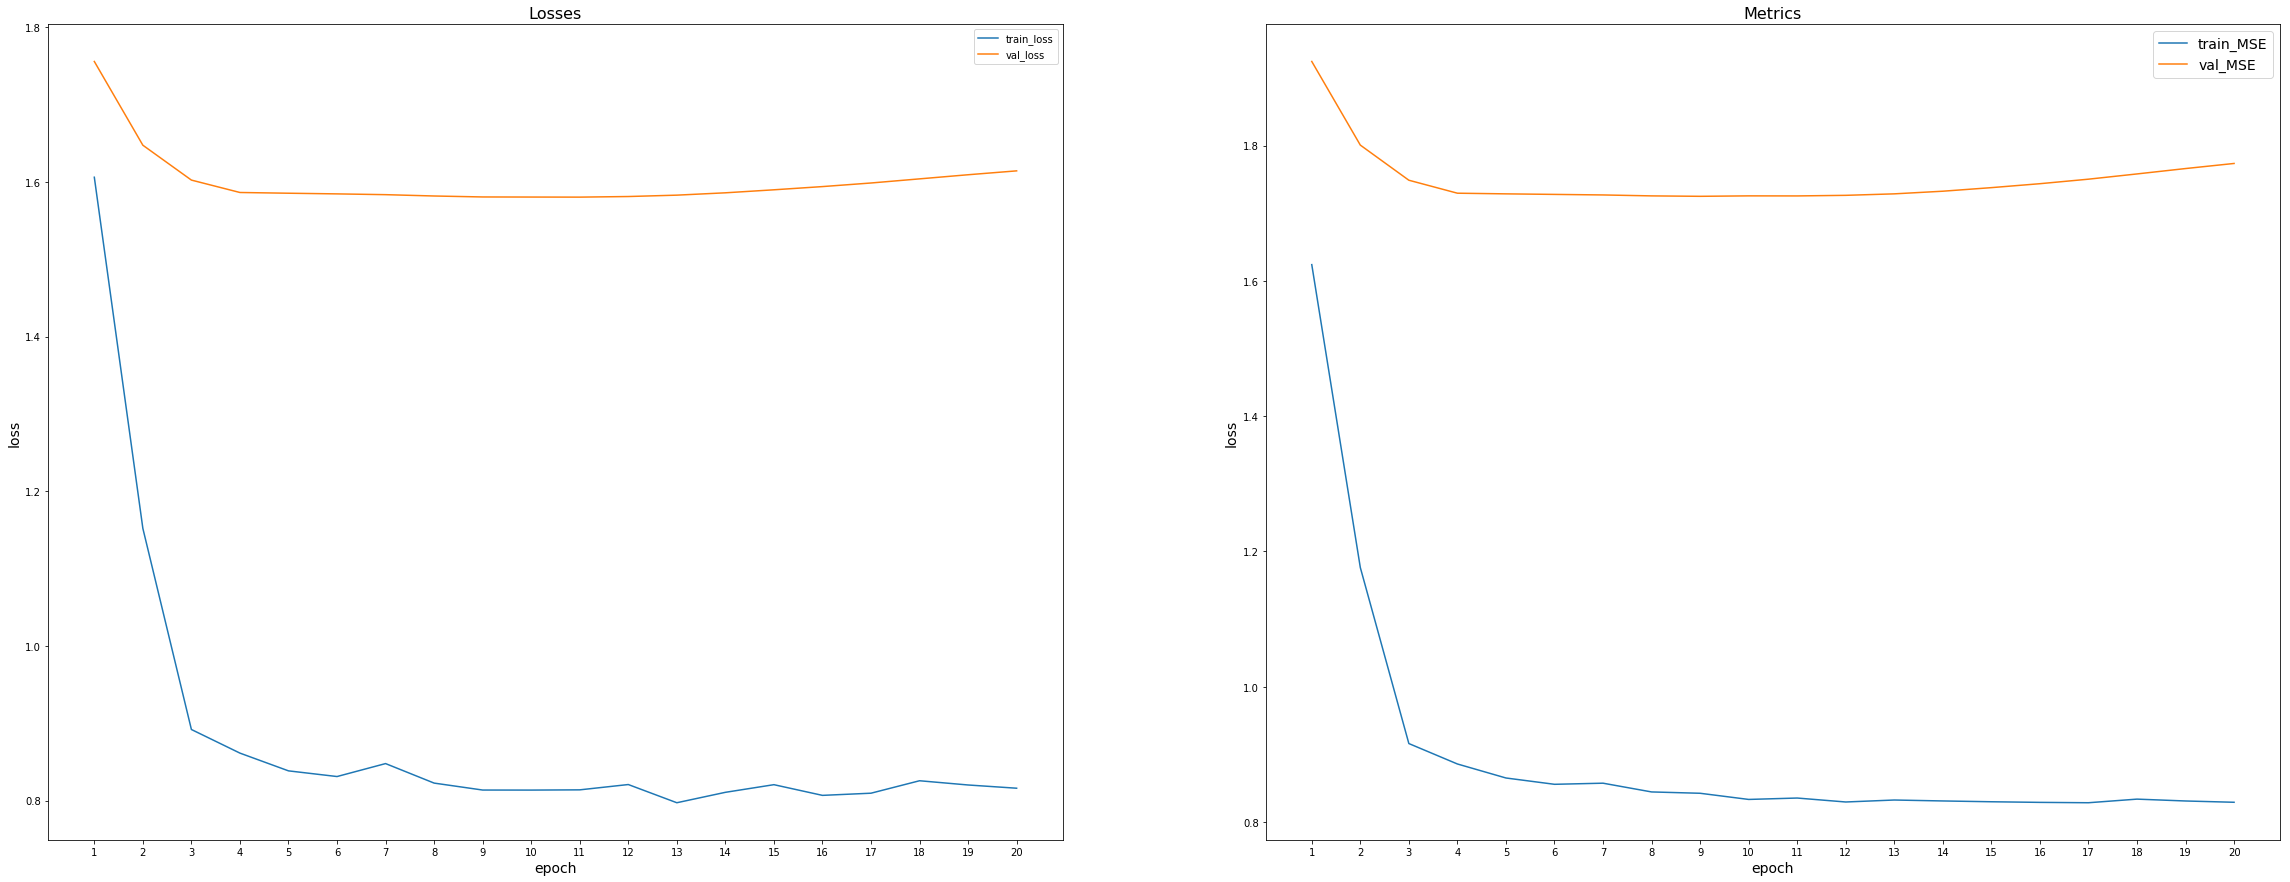

In [68]:
plot_history(history=history)

# 2) Output_size сеток с одномерным аутпутом (предполагаем независимость всех компонент силы)

Просто обучаю набор сеток на задачу регрессии, в качестве метрики для каждой сетки буду использовать MSE, а итоговая метрика - сумма MSE для каждой сетки

(Просто делаю массив из экземпляров сеток, optim-ов, loss-ов и потом циклом по ним делаю ровно тот же самый вызов history )

In [69]:
# Всем сеткам делаю абсолютно одинаковые гиперпараметры

models = [SingleNet(output_size=1) for _ in range(CFG.output_size)]

lr = 4e-3
betas=(0.9, 0.999)
weight_decay=0.1

optims = [optim.Adam(model.parameters(), lr=lr, betas=betas, weight_decay=weight_decay) for model in models]

step_size = 5
gamma = 0.1

exp_schedulers = [lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) for optimizer in optims]

criterion = nn.MSELoss()

In [70]:
from collections import defaultdict

Самое главное при обучении этих моделей - то что у model[ i ] - таргет - это число force[ i ]

In [71]:
def train_models():
    '''
    
    Возвращает словарь из history для всех моделей: {1: history, 2: history, ...}

    '''

    histories = defaultdict(list)

    # Надо менять немного цикл обучения, чтобы таргетом для i сетки была i-ая компонента вектора силы

    # for i in range(CFG.output_size):
    #     histories[str(i)] = train(
    #         train_loader=train_loader,
    #         val_loader=val_loader,
    #         model=model,
    #         optimizer=optimizer,
    #         scheduler=exp_scheduler,
    #         criterion=nn.MSELoss(),
    #         epochs=10
    #     )

# 3) GPR модель 
    - (потом можно сюда навалить и сетку в качестве ядра и вообще deep GP юзать, плюс еще feature extractor в виде сверток юзать сначала, если очень большая матрица, но сначала надо обычный сделать)

## 3.1) Не стохастический подход

https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/Simple_GP_Regression.html - как обучать модели в gpytorch

https://docs.gpytorch.ai/en/v1.3.1/examples/04_Variational_and_Approximate_GPs/SVGP_Regression_CUDA.html - как обучать GP по мини батчам, когда данных слишком много

У авторов $C_{mn}$ - это матрица ковариации по всему датасету, а $d_{mn}$ - некоторое введенное расстояние между матрицами, чтобы мы могли использовать экспоненциальное ядро, короче нам надо какое-то ядро, которое две матрицы, а не два числа принимает

- Весьма убедительно считать расстояние между матрицами просто как l2 метрику между точками в NxN мерном пространстве

Короче надо GPR сделать, у которого точки - матрицы и прогнозируется векторная величина, то есть для матрицы $x_*$ из инпута мы должны получать: $\mu_* = E[f(x_*)]$ - трехмерное мат ожидание для предсказания и $S$

In [72]:
import gpytorch

- В предположении что компоненты силы независимы, можно использовать Batch Independent Multioutput GP, предсказывая [fx, fy, fz]

- Если предсказывать k проекций на все V_i, то компоненты уже зависимые и надо это учитывать и использовать другую модель: MultitaskGPModel

лосс делаем -mll: минус логарифм правдоподобия: $-log[p(output Y | test X)]$

In [213]:
# train_X = torch.stack([elem[0] for elem in train_data])
# train_Y = torch.stack([elem[1] for elem in train_data])

# val_X = torch.stack([elem[0] for elem in val_data])
# val_Y = torch.stack([elem[1] for elem in val_data])

fl = flattener()
train_X = fl(torch.stack([elem[0] for elem in train_data]))
train_Y = fl(torch.stack([elem[1] for elem in train_data]))

val_X = fl(torch.stack([elem[0] for elem in val_data]))
val_Y = fl(torch.stack([elem[1] for elem in val_data]))

**Про свертки и когда они ожидаемо будут и не будут работать:**

    - если мы используем обычный GP, то мы обязаны каждый шаг обучаться на всем train_X - так алгоритм работает, поэтому и сверточная сеть так же должна будет обучаться, по-сути с батч_сайз = дата_сайз, но оно так вычислительно неподъемно или просто не успеет за такое маленькое количество шагов обучиться

    - Поэтому стоит использовать алгоритм Stochastic Variational GP Regression, который подразумевает совместимость с torch.DataLoader, когда данных будет очень много, там используется стохастический алгоритм, позволяющий на батче обновлять параметры

In [214]:
class IndependentOutputsMultitaskGPModel(gpytorch.models.ExactGP):
    '''

    Class for multi output GPregression with independent components of output,
    formally we are training output_size GP models

    feature_extractor: torch network that consists only of convolutions (fully convolutional net)

    '''
    def __init__(self, train_x, train_y, likelihood, output_size=3, feature_extractor=None):
        super().__init__(train_x, train_y, likelihood)

        self.output_size = output_size

        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([output_size]))     # batch_shape позволяет нам для каждой модели отдельные параметры сделать
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([output_size])),
        )

        self.feature_extractor = flattener()
        if feature_extractor:
            self.feature_extractor = feature_extractor

        self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1., 1.)

    def forward(self, x):
        # print(f'{x.size()}')

        convoluted_n_flattened_x = self.feature_extractor(x)   # flattening
        convoluted_n_flattened_x = self.scale_to_bounds(convoluted_n_flattened_x)

        mean_x = self.mean_module(convoluted_n_flattened_x)
        covar_x = self.covar_module(convoluted_n_flattened_x)

        # print(f'Сайз выпрямленного:  {convoluted_n_flattened_x.size()} \n Сам выпрямленный: {convoluted_n_flattened_x}')

        return gpytorch.distributions.MultitaskMultivariateNormal.from_batch_mvn(
            gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        )

In [215]:
class MinusLogLikelihoodLoss:
    def __init__(self, likelihood, model):
        self.mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    def __call__(self, model_output, true_target):
        '''

        model_output: what model(train_x) returns, mll uses likelihood by itself

        returns -mll(output, target)

        '''
        return -self.mll(model_output, true_target)

In [216]:
def GP_train(likelihood, model, optimizer, loss_obj, training_iterations: int, train_X, train_Y, print_step=1, scheduler=None):
    '''

    loss_obj should be an object of a class, which has __call__ method

    to have a clear perspective: on a stochastic network training I used around 2500 iterations

    returns history of MSE and loss

    '''
    model.train()
    likelihood.train()

    history = defaultdict(list)

    # scaler = amp.GradScaler()
    
    # Здесь нам не надо running_loss и running_MSE, потому что подаем сразу весь датасета в типе non-stochastic GP

    # Здесь реально обучаются параметры GPR, поскольку некоторая параметрическая часть у GPR все-таки присутствует
    for i in range(training_iterations):
        optimizer.zero_grad()

        output = model(train_X)

        loss = loss_obj(output, train_Y)
        loss.backward()

        predictions = likelihood(model(train_X))
        mean = predictions.mean
        lower, upper = predictions.confidence_region()

        train_MSE = F.mse_loss(input=mean, target=train_Y, reduction='mean').item()

        print(f'Iter: {i + 1}, train_MSE = {train_MSE}, train_loss = {loss}') if i % print_step == 0 else 1

        optimizer.step()

        history['MSE'].append(train_MSE)
        history['loss'].append(loss.item())

        if scheduler:
            # Так как здесь обучение не по мини-батчам, то каждую итерацию обновление
            scheduler.step()

    return history

Можно еще в процессе обучения параметров периодически смотреть на качество на валидационной выборке

In [217]:
def GP_eval(likelihood, model, optimizer, loss_obj, val_X, val_Y):
    '''
    
    One go dataset evaluation function

    '''
    model.eval()
    likelihood.eval()

    with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
        output = model(val_X)
        loss = loss_obj(output, val_Y)

    predictions = likelihood(model(val_X))

    mean = predictions.mean
    lower, upper = predictions.confidence_region()

    val_MSE = F.mse_loss(input=mean, target=val_Y, reduction='mean').item()

    print(f'val_MSE = {val_MSE}, val_loss = {loss.item()}')

    return mean, lower, upper

In [236]:
class LargeFeatureExtractor(torch.nn.Sequential):
    def __init__(self):
        super(LargeFeatureExtractor, self).__init__()
        self.add_module('linear1', torch.nn.Linear(CFG.K * CFG.K, 1000))
        self.add_module('relu1', torch.nn.ReLU())
        self.add_module('linear2', torch.nn.Linear(1000, 500))
        self.add_module('relu2', torch.nn.ReLU())
        self.add_module('linear3', torch.nn.Linear(500, 50))
        self.add_module('relu3', torch.nn.ReLU())
        self.add_module('linear4', torch.nn.Linear(50, 2))

In [244]:
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=3)

model = IndependentOutputsMultitaskGPModel(train_X, train_Y, likelihood, feature_extractor=LargeFeatureExtractor())

if likelihood.num_tasks != model.output_size:
    raise Exception('Different output dimensions for model and likelihood')

optimizer = torch.optim.Adam(model.parameters(), lr=0.05, weight_decay=0.03)

loss_obj = MinusLogLikelihoodLoss(likelihood=likelihood, model=model)

exp_scheduler = lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)

In [245]:
train_history = GP_train(
    likelihood=likelihood,
    model=model,
    optimizer=optimizer,
    scheduler=None,
    loss_obj=loss_obj,

    training_iterations=100,

    train_X=train_X,
    train_Y=train_Y,

    print_step=5
)


Iter: 1, train_MSE = 0.27721360325813293, train_loss = 1.1862082481384277
Iter: 6, train_MSE = 0.27789610624313354, train_loss = 1.112740397453308
Iter: 11, train_MSE = 0.2778192162513733, train_loss = 1.0416325330734253
Iter: 16, train_MSE = 0.27731454372406006, train_loss = 0.9718726873397827
Iter: 21, train_MSE = 0.2776170074939728, train_loss = 0.9125633835792542
Iter: 26, train_MSE = 0.27727746963500977, train_loss = 0.8617236018180847
Iter: 31, train_MSE = 0.27739498019218445, train_loss = 0.8183579444885254
Iter: 36, train_MSE = 0.2773369550704956, train_loss = 0.797179639339447
Iter: 41, train_MSE = 0.27786144614219666, train_loss = 0.7822433114051819
Iter: 46, train_MSE = 0.27724042534828186, train_loss = 0.790104329586029
Iter: 51, train_MSE = 0.27725598216056824, train_loss = 0.7945685982704163
Iter: 56, train_MSE = 0.27791985869407654, train_loss = 0.7946692705154419
Iter: 61, train_MSE = 0.2773755192756653, train_loss = 0.7972681522369385
Iter: 66, train_MSE = 0.2777849137

In [228]:
val_X.size()

torch.Size([616, 4])

In [229]:
train_X.size()

torch.Size([1248, 4])

In [246]:
GP_eval(
    likelihood=likelihood,
    model=model,
    optimizer=optimizer,
    loss_obj=loss_obj,
    val_X=val_X,
    val_Y=val_Y
)

val_MSE = 0.5699175596237183, val_loss = 1.1506420373916626


(tensor([[0.0004, 0.0080, 0.0046],
         [0.0004, 0.0080, 0.0046],
         [0.0004, 0.0080, 0.0046],
         ...,
         [0.0004, 0.0080, 0.0046],
         [0.0004, 0.0080, 0.0046],
         [0.0004, 0.0080, 0.0046]], grad_fn=<ViewBackward0>),
 tensor([[-1.3782, -1.3033, -1.2259],
         [-1.3782, -1.3033, -1.2259],
         [-1.3782, -1.3033, -1.2259],
         ...,
         [-1.3782, -1.3033, -1.2259],
         [-1.3782, -1.3033, -1.2259],
         [-1.3782, -1.3033, -1.2259]], grad_fn=<SubBackward0>),
 tensor([[1.3789, 1.3194, 1.2351],
         [1.3789, 1.3194, 1.2351],
         [1.3789, 1.3194, 1.2351],
         ...,
         [1.3789, 1.3194, 1.2351],
         [1.3789, 1.3194, 1.2351],
         [1.3789, 1.3194, 1.2351]], grad_fn=<AddBackward0>))

## 3.2) Stochastic Variational GP Regression:

---

# Пока мои выводы / результаты: 

- Про сетки:
    - Поскольку в датасете огромное количество сил очень маленькие - модель не в состоянии научиться определять болшьие силы, надо какой-то кастомный лосс придумывать, учитывающий это

    - Пока по какой-то причине сетка просто выдает одинаковый аутпут на весь батч на большом количестве частиц (и со свертками и без, и при большом и при маленьком K)

    - Для 2 частиц с K = 2 на одной сетке получилось val_MSE = 0.75

    - Для 50 частиц с K = 25 вообще ничего не вышло, с K = 5 пока тоже

Поэтому я пока отложу идею с 3 сетками и попробую покрутить GPR

- Про GP:
    - на 50 частицах пока оно не учится...

    - 

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler, scaler=None):
    '''

    Функция обучения по всем батчам 1 раз (1 эпоха)

    scaler: gradient scaler from torch.amp, попозже добавлю обучение с ним

    '''
    model.train()
    scaler = amp.GradScaler()

    running_loss = 0.0
    running_MSE = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        optimizer.zero_grad()

        inputs = inputs.to(CFG.device)
        labels = labels.to(CFG.device)

        with amp.autocast(enabled=True):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)

        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        running_MSE += F.mse_loss(input=outputs, target=labels, reduction='sum').item()
        processed_data += inputs.size(0)

    scheduler.step()
              
    train_loss = running_loss / processed_data
    train_MSE = running_MSE / processed_data
    
    return train_loss, train_MSE